# Notebook 1: Data Cleaning & Exploration

## Goals
1. Load and explore all CSV files
2. Harmonize schema to: `row_name, section, is_calculated, standardized_name`
3. Lowercase standardized names for consistency
4. Clean up standardized names (systematically + fine comb)
5. Scan for mistakes in `section` and `is_calculated`
6. Save cleaned CSVs to `*_clean_label/` directories

In [1151]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')

## 1. Load All Raw Data

In [1152]:
# Define paths
base_path = Path('..')
bs_raw_path = base_path / 'balance_sheet_raw_label'
is_raw_path = base_path / 'income_statement_raw_label'
bs_clean_path = base_path / 'balance_sheet_clean_label'
is_clean_path = base_path / 'income_statement_clean_label'

# Create clean directories if they don't exist
bs_clean_path.mkdir(exist_ok=True)
is_clean_path.mkdir(exist_ok=True)

print(f"Balance Sheet files: {len(list(bs_raw_path.glob('*.csv')))}")
print(f"Income Statement files: {len(list(is_raw_path.glob('*.csv')))}")
print(f"Balance Sheet files: {len(list(bs_clean_path.glob('*.csv')))}")
print(f"Income Statement files: {len(list(is_clean_path.glob('*.csv')))}")

Balance Sheet files: 46
Income Statement files: 46
Balance Sheet files: 45
Income Statement files: 45


In [1153]:
# Load all balance sheets
bs_files = sorted(bs_raw_path.glob('*.csv'))
balance_sheets = {}

for file in bs_files:
    ticker = file.stem
    df = pd.read_csv(file)
    balance_sheets[ticker] = df
    
print(f"Loaded {len(balance_sheets)} balance sheets")
print(f"Companies: {list(balance_sheets.keys())}")

Loaded 46 balance sheets
Companies: ['AAPL', 'ABNB', 'ACN', 'ADBE', 'ADI', 'ADP', 'ADSK', 'AMAT', 'AMD', 'AMGN', 'AMZN', 'APD', 'AVGO', 'BA', 'BABA', 'BIDU', 'BKNG', 'CSCO', 'DHI', 'DIS', 'EL', 'EQIX', 'GOOG', 'HD', 'IBM', 'INTU', 'IR', 'JD', 'KBH', 'KO', 'LOW', 'LULU', 'MA', 'META', 'MMM', 'MSFT', 'NFLX', 'NKE', 'NVDA', 'SBD', 'SNA', 'TGT', 'TOL', 'UNH', 'UNP', 'V']


In [1154]:
# Load all income statements
is_files = sorted(is_raw_path.glob('*.csv'))
income_statements = {}

for file in is_files:
    ticker = file.stem
    df = pd.read_csv(file)
    income_statements[ticker] = df
    
print(f"Loaded {len(income_statements)} income statements")
print(f"Companies: {list(income_statements.keys())}")

Loaded 46 income statements
Companies: ['AAPL', 'ABNB', 'ACN', 'ADBE', 'ADI', 'ADP', 'ADSK', 'AMAT', 'AMD', 'AMGN', 'AMZN', 'APD', 'AVGO', 'BA', 'BABA', 'BIDU', 'BKNG', 'CSCO', 'DHI', 'DIS', 'EL', 'EQIX', 'GOOG', 'HD', 'IBM', 'INTU', 'IR', 'JD', 'KBH', 'KO', 'LOW', 'LULU', 'MA', 'META', 'MMM', 'MSFT', 'NFLX', 'NKE', 'NVDA', 'SBD', 'SNA', 'TGT', 'TOL', 'UNH', 'UNP', 'V']


## 2. Explore Current Schemas

In [1155]:
# Check balance sheet schema
print("Balance Sheet Schema:")
sample_bs = list(balance_sheets.values())[0]
print(sample_bs.columns.tolist())
print("\nSample rows:")
sample_bs.head(10)

Balance Sheet Schema:
['row_name', 'section', 'is_calculated', 'standardized_name', 'company']

Sample rows:


,row_name,section,is_calculated,standardized_name,company
0,Cash and cash equivalents,current_assets,False,cash_and_equivalents,AAPL
1,Marketable securities (current),current_assets,False,short_term_investments,AAPL
2,"Accounts receivable, net",current_assets,False,accounts_receivable_net,AAPL
3,Vendor non-trade receivables,current_assets,False,vendor_non_trade_receivables,AAPL
4,Inventories,current_assets,False,inventory,AAPL
5,Other current assets,current_assets,False,other_current_assets,AAPL
6,Total current assets,current_assets,True,total_current_assets,AAPL
7,Marketable securities (non-current),noncurrent_assets,False,long_term_marketable_securities,AAPL
8,"Property, plant and equipment, net",noncurrent_assets,False,property_plant_and_equipment,AAPL
9,Other non-current assets,noncurrent_assets,False,other_noncurrent_assets,AAPL


In [1156]:
# Check income statement schema
print("Income Statement Schema:")
sample_is = list(income_statements.values())[0]
print(sample_is.columns.tolist())
print("\nSample rows:")
sample_is.head(10)

Income Statement Schema:
['row_name', 'section', 'is_calculated', 'standardized_name', 'company']

Sample rows:


,row_name,section,is_calculated,standardized_name,company
0,Products (Net sales),income_statement,False,product_revenue,AAPL
1,Services (Net sales),income_statement,False,service_revenue,AAPL
2,Total net sales,income_statement,True,total_revenue,AAPL
3,Products (Cost of sales),income_statement,False,cost_of_revenue_product,AAPL
4,Services (Cost of sales),income_statement,False,cost_of_revenue_service,AAPL
5,Total cost of sales,income_statement,True,total_cost_of_sales,AAPL
6,Gross margin,income_statement,True,gross_profit,AAPL
7,Research and development,income_statement,False,research_and_development_expense,AAPL
8,"Selling, general and administrative",income_statement,False,selling_general_and_administrative_expense,AAPL
9,Total operating expenses,income_statement,True,total_operating_expenses,AAPL


## 3. Load and Clean Standardize Names

In [1157]:
balance_sheets_clean = balance_sheets.copy()
income_statements_clean = income_statements.copy()

# Lowercase AND strip whitespace from all standardized names
for ticker in balance_sheets_clean:
    balance_sheets_clean[ticker]['standardized_name'] = balance_sheets_clean[ticker]['standardized_name'].str.lower().str.strip()

for ticker in income_statements_clean:
    income_statements_clean[ticker]['standardized_name'] = income_statements_clean[ticker]['standardized_name'].str.lower().str.strip()
    
print("✓ Lowercased and stripped whitespace from all standardized names")

✓ Lowercased and stripped whitespace from all standardized names


## 4. Execute Existing Mapping Rules

In [1158]:
# ==========================================
# EXECUTE SAVED MAPPING RULES
# ==========================================
# Run this cell immediately after loading/harmonizing data 
# to ensure you are working with the latest cleaned version.
# 1. Apply Balance Sheet Mappings
bs_history_path = Path('bs_mapping_history.csv')
if bs_history_path.exists():
    print(f"Loading rules from {bs_history_path}...")
    bs_rules = pd.read_csv(bs_history_path)
    
    # Create dictionary: old -> new
    bs_map = dict(zip(bs_rules['old_standardized_name'], bs_rules['new_standardized_name']))
    
    print(f"Applying {len(bs_map)} rules to Balance Sheets...")
    total_edits = 0
    
    for ticker, df in balance_sheets_clean.items():
        # Check if any replacements are needed in this file
        mask = df['standardized_name'].isin(bs_map.keys())
        if mask.any():
            total_edits += mask.sum()
            df['standardized_name'] = df['standardized_name'].replace(bs_map)
            
    print(f"✓ Balance Sheets updated: {total_edits} cells changed.")
else:
    print("No balance sheet history file found. Skipping auto-mapping.")


# 2. Apply Income Statement Mappings
is_history_path = Path('is_mapping_history.csv')
if is_history_path.exists():
    print(f"\nLoading rules from {is_history_path}...")
    is_rules = pd.read_csv(is_history_path)
    
    # Create dictionary: old -> new
    is_map = dict(zip(is_rules['old_standardized_name'], is_rules['new_standardized_name']))
    
    print(f"Applying {len(is_map)} rules to Income Statements...")
    total_edits = 0
    
    for ticker, df in income_statements_clean.items():
        # Check if any replacements are needed in this file
        mask = df['standardized_name'].isin(is_map.keys())
        if mask.any():
            total_edits += mask.sum()
            df['standardized_name'] = df['standardized_name'].replace(is_map)
            
    print(f"✓ Income Statements updated: {total_edits} cells changed.")
else:
    print("\nNo income statement history file found. Skipping auto-mapping.")

Loading rules from bs_mapping_history.csv...
Applying 115 rules to Balance Sheets...
✓ Balance Sheets updated: 306 cells changed.

Loading rules from is_mapping_history.csv...
Applying 147 rules to Income Statements...
✓ Income Statements updated: 290 cells changed.


## 5. Explore and Clean Balance Sheet

In [1159]:
# Collect all standardized names from balance sheets
bs_std_names = []
for df in balance_sheets_clean.values():
    bs_std_names.extend(df['standardized_name'].tolist())

bs_name_counts = Counter(bs_std_names)
print(f"Balance Sheet - Unique standardized names: {len(bs_name_counts)}")
print(f"Total line items: {len(bs_std_names)}")
print("\nMost common:")
for name, count in bs_name_counts.most_common(20):
    print(f"  {name}: {count}")

Balance Sheet - Unique standardized names: 110
Total line items: 1366

Most common:
  long_term_debt: 49
  cash_and_equivalents: 46
  total_assets: 46
  total_equity: 46
  total_liabilities_and_equity: 45
  accounts_payable: 44
  total_current_assets: 42
  property_plant_equipment: 42
  other_noncurrent_assets: 42
  total_current_liabilities: 42
  other_noncurrent_liabilities: 42
  accounts_receivable: 38
  goodwill: 37
  total_liabilities: 33
  short_term_investments: 31
  inventory: 31
  aoci: 29
  short_term_debt: 27
  intangibles_net: 27
  other_current_assets: 26


In [1160]:
# Analyze frequency of calculated columns in Balance Sheets
calculated_data = []
for ticker, df in balance_sheets_clean.items():
    # Filter for rows where is_calculated is True
    # Assuming normalization step ran, this should be boolean
    calc_rows = df[df['is_calculated'] == True]
    
    # Get entries
    for name in calc_rows['standardized_name'].unique():
        calculated_data.append({'standardized_name': name, 'ticker': ticker})
if calculated_data:
    df_calc_raw = pd.DataFrame(calculated_data)
    
    # Group by standardized_name
    calc_summary = df_calc_raw.groupby('standardized_name').agg(
        frequency=('ticker', 'count'),
        tickers=('ticker', lambda x: list(sorted(x)))
    ).reset_index()
    
    # Sort descending by frequency
    calc_summary = calc_summary.sort_values('frequency', ascending=False).reset_index(drop=True)
    
    print(f"Found {len(calc_summary)} unique calculated standardized names.")
    
    # Set option to view full lists of tickers
    pd.set_option('display.max_colwidth', 100) 
    display(calc_summary)
else:
    print("No calculated items found. Ensure 'is_calculated' column is boolean True.")

Found 14 unique calculated standardized names.


,standardized_name,frequency,tickers
0,total_assets,46,"[AAPL, ABNB, ACN, ADBE, ADI, ADP, ADSK, AMAT, AMD, AMGN, AMZN, APD, AVGO, BA, BABA, BIDU, BKNG, ..."
1,total_equity,46,"[AAPL, ABNB, ACN, ADBE, ADI, ADP, ADSK, AMAT, AMD, AMGN, AMZN, APD, AVGO, BA, BABA, BIDU, BKNG, ..."
2,total_liabilities_and_equity,45,"[AAPL, ABNB, ACN, ADBE, ADI, ADP, ADSK, AMAT, AMD, AMGN, AMZN, APD, AVGO, BA, BABA, BIDU, BKNG, ..."
3,total_current_assets,42,"[AAPL, ABNB, ACN, ADBE, ADI, ADP, ADSK, AMAT, AMD, AMGN, AMZN, APD, AVGO, BA, BABA, BIDU, BKNG, ..."
4,total_current_liabilities,42,"[AAPL, ABNB, ACN, ADBE, ADI, ADP, ADSK, AMAT, AMD, AMGN, AMZN, APD, AVGO, BA, BABA, BIDU, BKNG, ..."
5,total_liabilities,33,"[AAPL, ABNB, ADBE, ADP, AMAT, APD, AVGO, BA, BABA, BIDU, BKNG, CSCO, DHI, EQIX, GOOG, HD, IBM, I..."
6,total_parent_equity,9,"[BA, BABA, DHI, DIS, IR, KO, MA, SNA, TOL]"
7,total_noncurrent_liabilities,8,"[AAPL, ACN, ADI, APD, BIDU, EL, JD, TGT]"
8,total_noncurrent_assets,6,"[AAPL, ACN, ADI, APD, BIDU, JD]"
9,total_cash_and_investments,4,"[DHI, GOOG, KO, MSFT]"


In [1161]:
# Find rare standardized names (appear only once)
print("Balance Sheet - Rare names (appear only once):")
rare_bs = [name for name, count in bs_name_counts.items() if count == 1]
for name in rare_bs:
    for ticker, df in balance_sheets_clean.items():
        if name in df['standardized_name'].values:
            print(f"  {name} (from {ticker}.csv)")
            break



Balance Sheet - Rare names (appear only once):
  deferred_contract_costs (from ADP.csv)
  dividends_payable (from ADP.csv)
  property_plant_equipment_gross (from APD.csv)
  statutory_reserves (from BABA.csv)
  licensed_copyrights (from BIDU.csv)
  due_from_related_parties_noncurrent (from BIDU.csv)
  current_portion_convertible_debt (from BIDU.csv)
  noncurrent_assets_header (from CSCO.csv)
  noncurrent_liabilities_header (from CSCO.csv)
  total_inventory (from DHI.csv)
  content_costs_noncurrent (from DIS.csv)
  stock_dividends (from EQIX.csv)
  deferred_costs_noncurrent (from IBM.csv)
  liabilities_header (from IBM.csv)
  financial_services_assets (from KBH.csv)
  financial_services_liabilities (from KBH.csv)
  indefinite_lived_trademarks (from KO.csv)
  retained_earnings_deficit (from LOW.csv)
  current_content_liabilities (from NFLX.csv)
  long_term_content_liabilities (from NFLX.csv)
  franchisee_deposits_liability (from SNA.csv)
  buildings_and_improvements (from TGT.csv)
  fixtu

In [1162]:
# # Analyze specific company balance sheet frequencies
target_ticker = 'SBD'  # Change this to any company code you loaded
if target_ticker in balance_sheets_clean:
    # Get that company's data
    df_analysis = balance_sheets_clean[target_ticker].copy()
    
    # Map the global counts we calculated earlier
    df_analysis['global_frequency'] = df_analysis['standardized_name'].map(bs_name_counts)
    
    # Filter to just the relevant columns
    result_df = df_analysis[['standardized_name', 'global_frequency']]
    
    # Sort by frequency (rare items first are usually what you want to fix)
    result_df = result_df.sort_values('global_frequency', ascending=True)
    
    print(f"Balance Sheet Analysis for {target_ticker}:")
    display(result_df)
else:
    print(f"Company {target_ticker} not found in balance sheets.")

Balance Sheet Analysis for SBD:


,standardized_name,global_frequency
10,current_portion_long_term_debt,23
12,accrued_liabilities,23
3,other_current_assets,26
9,short_term_debt,27
2,inventory,31
16,total_liabilities,33
6,goodwill,37
1,accounts_receivable,38
4,total_current_assets,42
5,property_plant_equipment,42


In [1163]:
# Fuzzy search (substring match) for standardized names
search_terms = [
    'notes_rec',
]
print(f"--- Fuzzy Search Analysis for {len(search_terms)} terms ---\n")
for term in search_terms:
    print(f"SEARCH TERM: '{term}'")
    print("-" * 40)
    
    # 1. Search Balance Sheets
    bs_hits = {} # Store {ticker: [matched_names]}
    for ticker, df in balance_sheets_clean.items():
        matches = df[df['standardized_name'].str.contains(term, case=False, na=False)]['standardized_name'].unique()
        if len(matches) > 0:
            bs_hits[ticker] = list(matches)
            
    print(f"  Balance Sheet Matches: {len(bs_hits)} companies")
    for ticker, names in bs_hits.items():
        print(f"    {ticker}: {names}")
        
    print("\n")

--- Fuzzy Search Analysis for 1 terms ---

SEARCH TERM: 'notes_rec'
----------------------------------------
  Balance Sheet Matches: 6 companies
    APD: ['noncurrent_notes_receivables']
    BA: ['current_notes_receivables', 'noncurrent_notes_receivables']
    CSCO: ['current_notes_receivables', 'noncurrent_notes_receivables']
    IBM: ['current_notes_receivables', 'noncurrent_notes_receivables']
    INTU: ['current_notes_receivables']
    SNA: ['current_notes_receivables', 'noncurrent_notes_receivables']




In [1164]:
# ==========================================
# 1. DEFINE NEW BALANCE SHEET CHANGES HERE
# ==========================================

# Add your new replacements to this list tuple format: ('old', 'new')
new_changes = [
    # ('accounts_payable_and_accrued', 'accounts_payable'),
    # ('prop_plant_equip', 'ppe_net'),
    ('noncurrent_finance_receivables_net', 'noncurrent_notes_receivables'),
    ('current_finance_receivables_net', 'current_notes_receivables'),
    ('noncurrent_contract_receivables_net', 'noncurrent_notes_receivables'),
    ('current_contract_receivables_net', 'current_notes_receivables'),
]



# Path specifically for Balance Sheet mapping history
bs_history_file = Path('bs_mapping_history.csv')
# 2. Load existing history or create new DataFrame
if bs_history_file.exists():
    bs_mapping_df = pd.read_csv(bs_history_file)
else:
    bs_mapping_df = pd.DataFrame(columns=['old_standardized_name', 'new_standardized_name'])

# 3. Validate and Process changes
if new_changes:
    # Convert new changes to DataFrame
    new_df = pd.DataFrame(new_changes, columns=['old_standardized_name', 'new_standardized_name'])
    
    # --- VALIDATION START ---
    # Check 1: Internal conflicts in new_changes
    # Does the same 'old_name' map to different 'new_names' within the new batch?
    dup_checks = new_df.groupby('old_standardized_name')['new_standardized_name'].nunique()
    conflicts = dup_checks[dup_checks > 1]
    
    if not conflicts.empty:
        raise ValueError(f"CRITICAL ERROR: Internal conflict in new changes. One-to-many mapping detected for: {conflicts.index.tolist()}")
    
    # Check 2: Conflict with existing history
    # Does an 'old_name' in new_changes already exist in history mapping to a DIFFERENT 'new_name'?
    # Merge existing history with new changes on 'old_standardized_name'
    merged_check = pd.merge(new_df, bs_mapping_df, on='old_standardized_name', suffixes=('_new', '_existing'))
    
    # Filter for rows where the names are DIFFERENT
    conflicting_rows = merged_check[merged_check['new_standardized_name_new'] != merged_check['new_standardized_name_existing']]
    
    if not conflicting_rows.empty:
        error_msg = "\nCRITICAL ERROR: Mapping conflicts detected with existing history!\n"
        for _, row in conflicting_rows.iterrows():
            error_msg += f"  '{row['old_standardized_name']}': New='{row['new_standardized_name_new']}' vs Historic='{row['new_standardized_name_existing']}'\n"
        raise ValueError(error_msg)
    # --- VALIDATION END ---
    
    # If we pass validation, proceed to save (same logic as before)
    # Check for duplicates before appending to avoid redundant rows in CSV
    existing_pairs = set(zip(bs_mapping_df['old_standardized_name'], bs_mapping_df['new_standardized_name']))
    
    unique_new_rows = []
    for _, row in new_df.iterrows():
        pair = (row['old_standardized_name'], row['new_standardized_name'])
        if pair not in existing_pairs:
            unique_new_rows.append(row)
            existing_pairs.add(pair)
            
    if unique_new_rows:
        unique_df = pd.DataFrame(unique_new_rows)
        bs_mapping_df = pd.concat([bs_mapping_df, unique_df], ignore_index=True)
        
        # Save immediately to persist new rules
        bs_mapping_df.to_csv(bs_history_file, index=False)
        print(f"Added {len(unique_new_rows)} new mappings. History saved to: {bs_history_file}")
    else:
        print("No new unique mappings to add.")

# 4. EXECUTE ALL CHANGES (Historical + New)
total_edits = 0
mapping_dict = dict(zip(bs_mapping_df['old_standardized_name'], bs_mapping_df['new_standardized_name']))
print("\nApplying rules to Balance Sheets...")
for ticker, df in balance_sheets_clean.items():
    # Only replace if values exist (optimization)
    vals_to_replace = df['standardized_name'].isin(mapping_dict.keys())
    if vals_to_replace.any():
        total_edits += vals_to_replace.sum()
        df['standardized_name'] = df['standardized_name'].replace(mapping_dict)
print(f"✓ Applied {len(mapping_dict)} total rules from history.")
print(f"✓ Total cells updated in this run: {total_edits}")

# Display most recent rules added
if not bs_mapping_df.empty:
    print("\nMost recently added rules:")
    display(bs_mapping_df.tail(10))

No new unique mappings to add.

Applying rules to Balance Sheets...
✓ Applied 115 total rules from history.
✓ Total cells updated in this run: 2

Most recently added rules:


,old_standardized_name,new_standardized_name
105,loans_payable,short_term_debt
106,due_to_related_parties_current,short_term_debt_related_party
107,short_term_investment,short_term_investments
108,marketable_securities_current,short_term_investments
109,total_cash_and_equivalents,total_cash_and_investments
110,current_assets_operating_subtotal,total_current_operating_assets
111,current_liabilities_operating_subtotal,total_current_operating_liabilities
112,total_equity_combined,total_equity
113,total_liabilities_mezzanine_and_equity,total_liabilities_and_equity
114,total_equity_parent,total_parent_equity


## 6. Clean and Explore Income Statement

In [1165]:
# Collect all standardized names from income statements
is_std_names = []
for df in income_statements_clean.values():
    is_std_names.extend(df['standardized_name'].tolist())

is_name_counts = Counter(is_std_names)
print(f"Income Statement - Unique standardized names: {len(is_name_counts)}")
print(f"Total line items: {len(is_std_names)}")
print("\nMost common:")
for name, count in is_name_counts.most_common(20):
    print(f"  {name}: {count}")

Income Statement - Unique standardized names: 51
Total line items: 713

Most common:
  segment_revenue: 49
  income_before_taxes: 46
  income_tax_provision: 46
  net_income: 46
  operating_income: 42
  cost_of_revenue: 41
  other_income_expense_net: 34
  interest_expense: 29
  total_operating_expenses: 28
  revenue: 26
  research_and_development_expense: 24
  total_revenue: 21
  sales_and_marketing_expense: 21
  general_and_administrative_expense: 21
  gross_profit: 20
  sales_general_and_administrative_expense: 20
  segment_cost_of_revenue: 19
  restructuring_and_impairment_charges: 19
  investment_income_net: 18
  interest_income: 16


In [1166]:
# Analyze frequency of calculated columns in Balance Sheets
calculated_data = []
for ticker, df in income_statements_clean.items():
    # Filter for rows where is_calculated is True
    # Assuming normalization step ran, this should be boolean
    calc_rows = df[df['is_calculated'] == True]
    
    # Get entries
    for name in calc_rows['standardized_name'].unique():
        calculated_data.append({'standardized_name': name, 'ticker': ticker})
if calculated_data:
    df_calc_raw = pd.DataFrame(calculated_data)
    
    # Group by standardized_name
    calc_summary = df_calc_raw.groupby('standardized_name').agg(
        frequency=('ticker', 'count'),
        tickers=('ticker', lambda x: list(sorted(x)))
    ).reset_index()
    
    # Sort descending by frequency
    calc_summary = calc_summary.sort_values('frequency', ascending=False).reset_index(drop=True)
    
    print(f"Found {len(calc_summary)} unique calculated standardized names.")
    
    # Set option to view full lists of tickers
    pd.set_option('display.max_colwidth', 100) 
    display(calc_summary)
else:
    print("No calculated items found. Ensure 'is_calculated' column is boolean True.")

Found 13 unique calculated standardized names.


,standardized_name,frequency,tickers
0,income_before_taxes,46,"[AAPL, ABNB, ACN, ADBE, ADI, ADP, ADSK, AMAT, AMD, AMGN, AMZN, APD, AVGO, BA, BABA, BIDU, BKNG, ..."
1,net_income,46,"[AAPL, ABNB, ACN, ADBE, ADI, ADP, ADSK, AMAT, AMD, AMGN, AMZN, APD, AVGO, BA, BABA, BIDU, BKNG, ..."
2,operating_income,42,"[AAPL, ABNB, ACN, ADBE, ADI, ADSK, AMAT, AMD, AMGN, AMZN, APD, AVGO, BA, BABA, BIDU, BKNG, CSCO,..."
3,total_operating_expenses,28,"[AAPL, ABNB, ACN, ADBE, ADI, ADP, ADSK, AMAT, AMD, AMGN, AMZN, AVGO, BIDU, BKNG, CSCO, EL, EQIX,..."
4,total_revenue,21,"[AAPL, ADBE, ADP, ADSK, AMGN, AMZN, BA, BIDU, BKNG, CSCO, EQIX, IBM, INTU, JD, KBH, LOW, MSFT, T..."
5,gross_profit,20,"[AAPL, ADBE, ADI, ADSK, AMAT, AMD, AVGO, CSCO, EL, EQIX, HD, IBM, IR, KO, LULU, MSFT, NKE, NVDA,..."
6,total_other_income_expense_net,10,"[ADBE, ADI, AMZN, BIDU, EQIX, HD, IBM, MA, NVDA, V]"
7,total_cost_of_revenue,9,"[AAPL, ADBE, ADSK, AMD, AVGO, BA, CSCO, MSFT, TOL]"
8,revenue_subtotal,1,[ADSK]
9,segment_gross_profit,1,[TOL]


In [1167]:
# Check which companies are MISSING a specific standardized name
target_missing_name = 'operating_income'  # <--- Change this term

# Check Income Statements
missing_is = []
for ticker, df in income_statements_clean.items():
    if target_missing_name not in df['standardized_name'].values:
        missing_is.append(ticker)
        
print(f"\nIncome Statements missing '{target_missing_name}': {len(missing_is)}")
if missing_is:
    print(f"  Tickers: {sorted(missing_is)}")


Income Statements missing 'operating_income': 4
  Tickers: ['ADP', 'DHI', 'IBM', 'NKE']


In [1168]:
print("\nIncome Statement - Rare names (appear only once):")
rare_is = [name for name, count in is_name_counts.items() if count == 1]
for name in rare_is:
    for ticker, df in income_statements_clean.items():
        if name in df['standardized_name'].values:
            print(f"  {name} (from {ticker}.csv)")
            break


Income Statement - Rare names (appear only once):
  total_expenses (from ADP.csv)
  revenue_subtotal (from ADSK.csv)
  amortization_internal (from ADSK.csv)
  foreign_exchange_gain_loss_net (from BIDU.csv)
  gross_revenue (from CSCO.csv)
  revenue_adjustments (from CSCO.csv)
  sales_discounts (from CSCO.csv)
  other_pension_benefit_costs (from EL.csv)
  ip_and_development_income (from IBM.csv)


In [1169]:
# Fuzzy search (substring match) for standardized names
search_terms = [
    'dives',
]
print(f"--- Fuzzy Search Analysis for {len(search_terms)} terms ---\n")
for term in search_terms:
    print(f"SEARCH TERM: '{term}'")
    print("-" * 40)

    is_hits = {}
    for ticker, df in income_statements_clean.items():
        matches = df[df['standardized_name'].str.contains(term, case=False, na=False)]['standardized_name'].unique()
        if len(matches) > 0:
            is_hits[ticker] = list(matches)
            
    print(f"\n  Income Statement Matches: {len(is_hits)} companies")
    for ticker, names in is_hits.items():
        print(f"    {ticker}: {names}")
        
    print("\n")

--- Fuzzy Search Analysis for 1 terms ---

SEARCH TERM: 'dives'
----------------------------------------

  Income Statement Matches: 8 companies
    BA: ['gain_loss_divestitures']
    EQIX: ['gain_loss_divestitures']
    JD: ['gain_loss_divestitures']
    LOW: ['gain_loss_divestitures']
    LULU: ['gain_loss_divestitures']
    MMM: ['gain_loss_divestitures']
    SBD: ['gain_loss_divestitures']
    UNH: ['gain_loss_divestitures']




In [1170]:
# ==========================================
# 1. DEFINE NEW INCOME STATEMENT CHANGES HERE
# ==========================================
# Add your new replacements to this list tuple format: ('old', 'new')
new_changes = [
    # ('net_sales', 'total_revenue'),
    # ('operating_loss_divestitures', 'gain_loss_divestitures'),
    ('loss_on_business_disposal_operating', 'gain_loss_divestitures'),
]


# Path specifically for Income Statement mapping history
is_history_file = Path('is_mapping_history.csv')
# 2. Load existing history or create new DataFrame
if is_history_file.exists():
    is_mapping_df = pd.read_csv(is_history_file)
else:
    is_mapping_df = pd.DataFrame(columns=['old_standardized_name', 'new_standardized_name'])
# 3. Validate and Process changes
if new_changes:
    # Convert new changes to DataFrame
    new_df = pd.DataFrame(new_changes, columns=['old_standardized_name', 'new_standardized_name'])
    
    # --- VALIDATION START ---
    # Check 1: Internal conflicts in new_changes
    # Does the same 'old_name' map to different 'new_names' within the new batch?
    dup_checks = new_df.groupby('old_standardized_name')['new_standardized_name'].nunique()
    conflicts = dup_checks[dup_checks > 1]
    
    if not conflicts.empty:
        raise ValueError(f"CRITICAL ERROR: Internal conflict in new changes. One-to-many mapping detected for: {conflicts.index.tolist()}")
    
    # Check 2: Conflict with existing history
    # Does an 'old_name' in new_changes already exist in history mapping to a DIFFERENT 'new_name'?
    # Merge existing history with new changes on 'old_standardized_name'
    merged_check = pd.merge(new_df, is_mapping_df, on='old_standardized_name', suffixes=('_new', '_existing'))
    
    # Filter for rows where the names are DIFFERENT
    conflicting_rows = merged_check[merged_check['new_standardized_name_new'] != merged_check['new_standardized_name_existing']]
    
    if not conflicting_rows.empty:
        error_msg = "\nCRITICAL ERROR: Mapping conflicts detected with existing history!\n"
        for _, row in conflicting_rows.iterrows():
            error_msg += f"  '{row['old_standardized_name']}': New='{row['new_standardized_name_new']}' vs Historic='{row['new_standardized_name_existing']}'\n"
        raise ValueError(error_msg)
    # --- VALIDATION END ---
    
    # If we pass validation, proceed to save (same logic as before)
    # Check for duplicates before appending to avoid redundant rows in CSV
    existing_pairs = set(zip(is_mapping_df['old_standardized_name'], is_mapping_df['new_standardized_name']))
    
    unique_new_rows = []
    for _, row in new_df.iterrows():
        pair = (row['old_standardized_name'], row['new_standardized_name'])
        if pair not in existing_pairs:
            unique_new_rows.append(row)
            existing_pairs.add(pair)
            
    if unique_new_rows:
        unique_df = pd.DataFrame(unique_new_rows)
        is_mapping_df = pd.concat([is_mapping_df, unique_df], ignore_index=True)
        
        # Save immediately to persist new rules
        is_mapping_df.to_csv(is_history_file, index=False)
        print(f"Added {len(unique_new_rows)} new mappings. History saved to: {is_history_file}")
    else:
        print("No new unique mappings to add.")
# 4. EXECUTE ALL CHANGES (Historical + New)
total_edits = 0
mapping_dict = dict(zip(is_mapping_df['old_standardized_name'], is_mapping_df['new_standardized_name']))
print("\nApplying rules to Income Statements...")
for ticker, df in income_statements_clean.items():
    # Only replace if values exist (optimization)
    vals_to_replace = df['standardized_name'].isin(mapping_dict.keys())
    if vals_to_replace.any():
        total_edits += vals_to_replace.sum()
        df['standardized_name'] = df['standardized_name'].replace(mapping_dict)
print(f"✓ Applied {len(mapping_dict)} total rules from history.")
print(f"✓ Total cells updated in this run: {total_edits}")
# Display most recent rules added
if not is_mapping_df.empty:
    print("\nMost recently added rules:")
    display(is_mapping_df.tail(10))

No new unique mappings to add.

Applying rules to Income Statements...
✓ Applied 147 total rules from history.
✓ Total cells updated in this run: 6

Most recently added rules:


,old_standardized_name,new_standardized_name
138,premium_revenue,segment_revenue
139,information_technology_expense,technology_and_infrastructure_expense
140,total_cost_of_goods_sold,total_cost_of_revenue
141,total_cost_of_sales,total_cost_of_revenue
142,total_costs_and_expenses,total_cost_of_revenue
143,total_non_operating_income_expense,total_other_income_expense_net
144,total_non_operating_interest_and_other_net,total_other_income_expense_net
145,total_expense_and_other_income,total_other_income_expense_net
146,total_non_operating_income_expense_net,total_other_income_expense_net
147,loss_on_business_disposal_operating,gain_loss_divestitures


## 7. Visualize Distribution

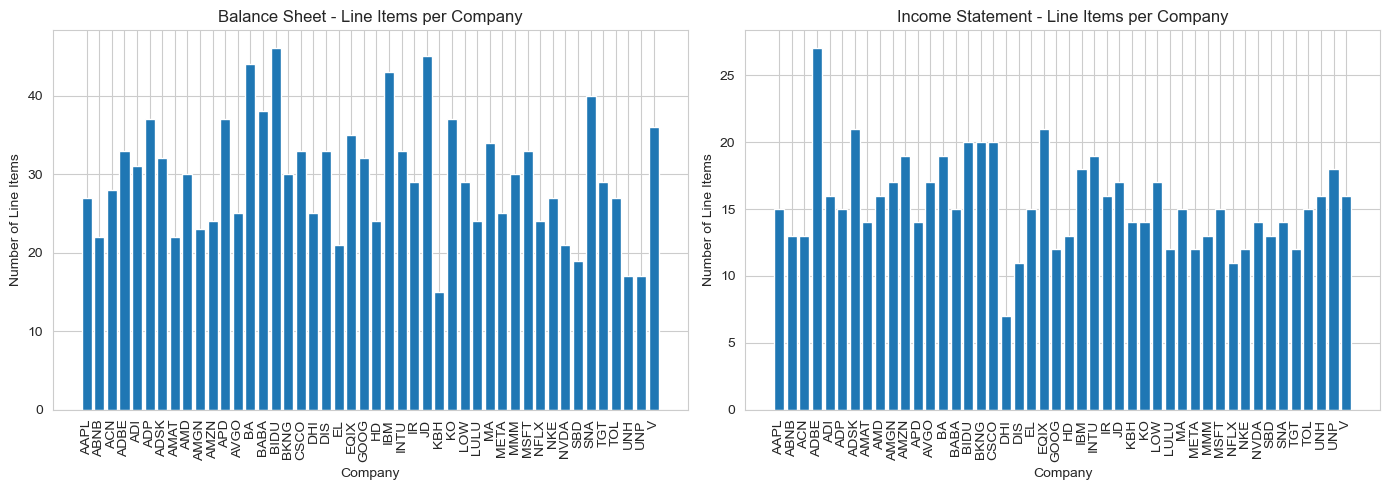

In [1171]:
# Plot distribution of line items per company
bs_counts = {ticker: len(df) for ticker, df in balance_sheets_clean.items()}
is_counts = {ticker: len(df) for ticker, df in income_statements_clean.items()}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.bar(bs_counts.keys(), bs_counts.values())
ax1.set_title('Balance Sheet - Line Items per Company')
ax1.set_xlabel('Company')
ax1.set_ylabel('Number of Line Items')
ax1.tick_params(axis='x', rotation=90)

ax2.bar(is_counts.keys(), is_counts.values())
ax2.set_title('Income Statement - Line Items per Company')
ax2.set_xlabel('Company')
ax2.set_ylabel('Number of Line Items')
ax2.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

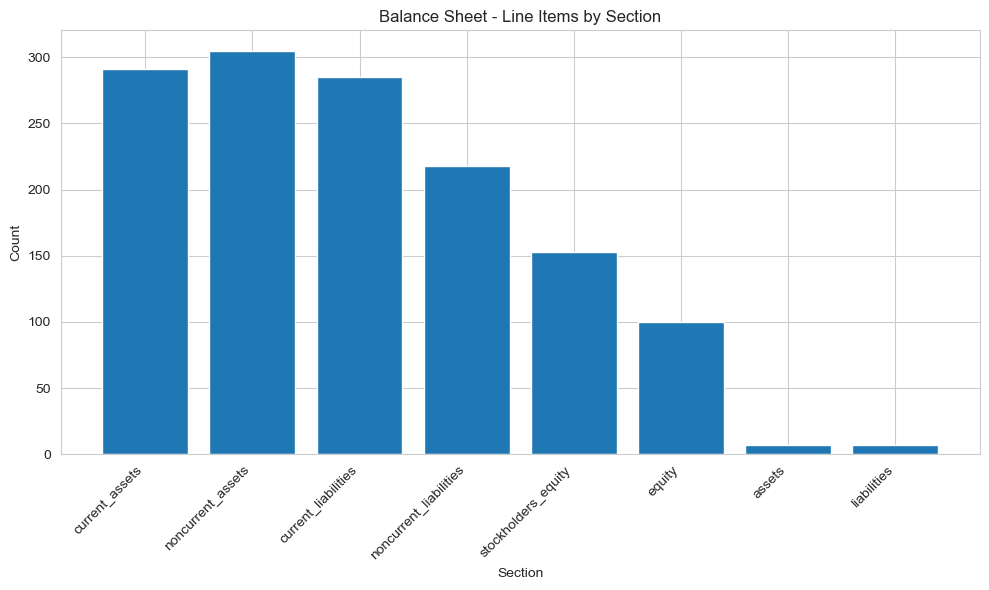

In [1172]:
# Plot section distribution for balance sheets
section_counts = Counter()
for df in balance_sheets_clean.values():
    section_counts.update(df['section'].tolist())

plt.figure(figsize=(10, 6))
plt.bar(section_counts.keys(), section_counts.values())
plt.title('Balance Sheet - Line Items by Section')
plt.xlabel('Section')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 8. Save Cleaned Data

In [1173]:
# Save cleaned balance sheets
for ticker, df in balance_sheets_clean.items():
    output_path = bs_clean_path / f"{ticker}.csv"
    df.to_csv(output_path, index=False)

print(f"✓ Saved {len(balance_sheets_clean)} cleaned balance sheets to {bs_clean_path}")

✓ Saved 46 cleaned balance sheets to ..\balance_sheet_clean_label


In [1174]:
# Save cleaned income statements
for ticker, df in income_statements_clean.items():
    output_path = is_clean_path / f"{ticker}.csv"
    df.to_csv(output_path, index=False)

print(f"✓ Saved {len(income_statements_clean)} cleaned income statements to {is_clean_path}")

✓ Saved 46 cleaned income statements to ..\income_statement_clean_label


In [1175]:
# List of files to sort
files_to_sort = ['bs_mapping_history.csv', 'is_mapping_history.csv']
for filename in files_to_sort:
    file_path = Path(filename)
    if file_path.exists():
        # Read the CSV
        df = pd.read_csv(file_path)
        
        # Sort by the second column (new_standardized_name)
        # df.columns[1] dynamically gets the name of the second column
        sort_col = df.columns[1]
        df = df.sort_values(by=sort_col)
        
        # Save back to CSV without the index
        df.to_csv(file_path, index=False)
        print(f"Successfully sorted '{filename}' by column '{sort_col}'.")
    else:
        print(f"File not found: {filename}")

Successfully sorted 'bs_mapping_history.csv' by column 'new_standardized_name'.
Successfully sorted 'is_mapping_history.csv' by column 'new_standardized_name'.
